# Can a fully connect model do better than the non-machine learning baseline?

## TLDR; yep, we get a lower test MAE than the LSTM with dropout (o:

For now, we make no changes to;
- optimizer (inc. learning rate) or loss function
- model depth or width
- batch size

We have a couple of functions (`new_model` and `compile_and_fit`) that make it easy to try different combinations of ideas;

## `new_model`

### `fit_residual`

Can a model learn to correct the errors of the common-sense, non-machine learning baseline?

When `fit_residual=True`, we add the temperature as it is "now" to the output of the last dense layer to get our final predictions.

### `temporal_weight_range`

Can we tell our model to pay more attention to data from the recent past?

e.g. `[0.0, 2.0]` reduces the magnitude of earlier observations and increases the magnitude of recent observations.

### `l2_factor`

See [regularizers.l2](https://keras.io/api/layers/regularizers/)

### `dropout_rate`

See [layers.Dropout](https://keras.io/api/layers/regularization_layers/dropout/)

### `final_activation`

Does it help to limit output values to a specific range?

`sigmoid_range` can take the output of the last dense layer and make sure it is within a range of values just a little wider than the min/max "T (degC)" seen in the training data.

## `compile_and_fit`

Compile and fit `model` saving checkpoints to `f'jena_dense_{model_tag}.keras'`.

## `augment`

Can we help the model to generalize by aumenting input data?

`augment_input` changes features (but not "T (degC)") by a little bit - all samples in a batch get the same adjustment.

## `evaluate_model`

Calculates metrics for a model checkpoint saved as `f'jena_dense_{model_tag}.keras'` using the test dataset.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import callbacks
from matplotlib import pyplot as plt
from pathlib import Path
from functools import partial
try:
    from utils.plot_history import *
except ModuleNotFoundError:
    if not Path('plot_history.py').is_file():
        !wget https://raw.githubusercontent.com/pete88b/deep_learning_with_python/main/utils/plot_history.py
    from plot_history import *

In [2]:
Path('data/models').mkdir(exist_ok=True, parents=True)
if not Path('jena_climate_2009_2016.csv.zip').is_file():
    !wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
    !unzip jena_climate_2009_2016.csv.zip -d data
with open("data/jena_climate_2009_2016.csv") as f:
    data = f.read()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(len(header), 'features', len(lines), 'rows of data')
print(header)

15 features 420451 rows of data
['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']


In [3]:
lines[0]

'01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30'

# Convert data to np

In [4]:
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:] # features inc. temp

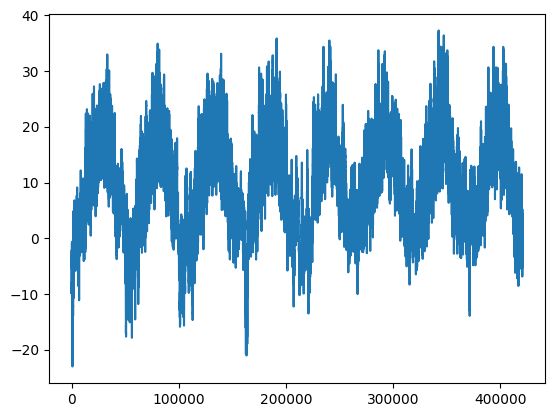

In [5]:
plt.plot(range(len(temperature)), temperature)
plt.show()

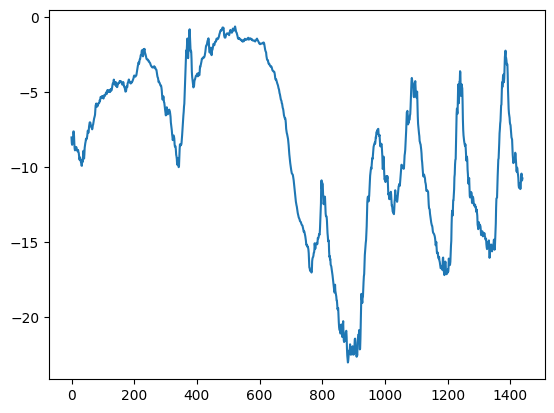

In [6]:
plt.plot(range(1440), temperature[:1440])
plt.show()

# Work out how many samples will be in each dataset

In [7]:
n_train_samples = len(temperature) // 2
n_val_samples = len(temperature) // 4
n_test_samples = len(temperature) - n_train_samples-n_val_samples
n_train_samples, n_val_samples, n_test_samples

(210225, 105112, 105114)

# Normalize data using train stats

In [8]:
mean = raw_data[:n_train_samples].mean(axis=0)
std = raw_data[:n_train_samples].std(axis=0)
raw_data -= mean
raw_data /= std

# Quick look at the normalized data

In [9]:
raw_data[:n_train_samples].min(axis=0), raw_data[:n_train_samples].max(axis=0)

(array([-8.83578303, -3.6296845 , -3.64386561, -4.14164583, -3.78396719,
        -1.60442381, -2.02660981, -0.82847061, -2.01707768, -2.02445711,
        -3.78222606, -1.40179408, -1.53267098, -2.055211  ]),
 array([2.83249825, 3.0822195 , 3.04828935, 2.29751734, 1.45093305,
        6.03506343, 3.63786658, 8.00243978, 3.67653916, 3.65929764,
        4.16486633, 8.13792568, 8.5833148 , 2.13813385]))

# Augmentation function

this just changes features (but not "T (degC)") by a little bit - all samples in a batch get the same adjustment

In [10]:
@tf.function
def augment_input(x):
    aug_mask = tf.random.normal([14,], stddev=0.5, dtype=tf.dtypes.float64)
    aug_mask = aug_mask * [1,0,1,1,1,1,1,1,1,1,1,1,1,1] # leave "T (degC)" alone
    return x + aug_mask

# Create datasets

In [11]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256
def new_dataset(start_index, end_index):
    dataset = keras.utils.timeseries_dataset_from_array(
            raw_data[:-delay],
            targets=temperature[delay:],
            sampling_rate=sampling_rate,
            sequence_length=sequence_length,
            shuffle=start_index == 0, # only shuffle train
            batch_size=batch_size if start_index == 0 else 2**12,
            start_index=start_index,
            end_index=end_index)
    return dataset.prefetch(tf.data.AUTOTUNE)
train_dataset = new_dataset(0, n_train_samples)
train_dataset_augment = train_dataset.map(
        lambda x,y: (augment_input(x), y), num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = new_dataset(n_train_samples, n_train_samples + n_val_samples)
test_dataset = new_dataset(n_train_samples+n_val_samples, None)

In [12]:
for xb,yb in test_dataset:
    print(xb.shape, yb.shape, tf.reduce_mean(xb))
    break

(4096, 120, 14) (4096,) tf.Tensor(-0.21806272475450836, shape=(), dtype=float64)


In [13]:
xb[0][1] # input features for 1 timestep

<tf.Tensor: shape=(14,), dtype=float64, numpy=
array([ 0.84428144, -1.0997516 , -1.15559764, -1.15581759,  0.23015792,
       -0.9729525 , -1.11267343, -0.58316754, -1.11688609, -1.11962811,
        1.26709988,  1.15430308,  1.34715646,  1.00476592])>

# Evaluate the common-sense, non-machine learning baseline

In [14]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

In [15]:
print('Naive validation MAE', evaluate_naive_method(val_dataset))
print('Naive test MAE', evaluate_naive_method(test_dataset))

Naive validation MAE 2.4417357485655167
Naive test MAE 2.621898451761206


# Functions to build and train a model

In [16]:
@tf.function
def sigmoid_range(x):
    "Force output to be between -25 and 40"
    return keras.activations.sigmoid(x) * 65.0 - 25.0
# @tf.function
# def sigmoid_range(x, low, high):
#     "Force output to be between low and high"
#     return keras.activations.sigmoid(x) * (high - low) + low

In [17]:
def new_model(temporal_weight_range=None, l2_factor=None, dropout_rate=None, 
              final_activation=None, fit_residual=False):
    inputs = layers.Input(shape=(sequence_length, raw_data.shape[-1]))
    if temporal_weight_range is not None:
        temporal_weight_mask = tf.linspace(temporal_weight_range[0], temporal_weight_range[1], 120)
        x = layers.Flatten()(inputs * tf.expand_dims(temporal_weight_mask, -1))
    else:
        x = layers.Flatten()(inputs)
    kernel_regularizer = None if l2_factor is None else regularizers.l2(l2_factor) 
    x = layers.Dense(16, activation='relu', kernel_regularizer=kernel_regularizer)(x)
    if dropout_rate is not None:
        x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(1, activation=final_activation)(x)
    if fit_residual:
        x = tf.expand_dims(inputs[:, -1, 1] * std[1] + mean[1], -1) + x
    return keras.Model(inputs, x)

In [18]:
def compile_and_fit(model, model_tag, augment=False):
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    kwargs = dict(monitor='val_mae', verbose=1)
    cbs = [callbacks.ModelCheckpoint(f'data/models/jena_dense_{model_tag}.keras', 
                                     save_best_only=True, **kwargs),
           callbacks.EarlyStopping(patience=2, **kwargs)]
    history = model.fit(train_dataset_augment if augment else train_dataset,
                        epochs=5,
                        validation_data=val_dataset,
                        callbacks=cbs)
    del history.history['loss'] # we'll just plot mae
    plot_history(history, ignore_first_n=0)

In [19]:
def evaluate_model(model_tag):
    model = keras.models.load_model(f'data/models/jena_dense_{model_tag}.keras', 
                                    custom_objects=dict(sigmoid_range=sigmoid_range))
    print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f} for model tag: {model_tag}")

# Start with the best model we have &darr; 

Note: we don't use augmentation by default

Epoch 1/5
810/819 [============================>.] - ETA: 0s - loss: 10.8944 - mae: 2.5379
Epoch 1: val_mae improved from inf to 2.33652, saving model to data/models/jena_dense_0.keras
819/819 [==============================] - 9s 10ms/step - loss: 10.8824 - mae: 2.5365 - val_loss: 9.3108 - val_mae: 2.3365
Epoch 2/5
809/819 [============================>.] - ETA: 0s - loss: 10.0890 - mae: 2.4461
Epoch 2: val_mae did not improve from 2.33652
819/819 [==============================] - 9s 11ms/step - loss: 10.0871 - mae: 2.4461 - val_loss: 9.6432 - val_mae: 2.3812
Epoch 3/5
818/819 [============================>.] - ETA: 0s - loss: 9.9282 - mae: 2.4262
Epoch 3: val_mae improved from 2.33652 to 2.30967, saving model to data/models/jena_dense_0.keras
819/819 [==============================] - 9s 11ms/step - loss: 9.9283 - mae: 2.4262 - val_loss: 9.1148 - val_mae: 2.3097
Epoch 4/5
810/819 [============================>.] - ETA: 0s - loss: 9.8570 - mae: 2.4188
Epoch 4: val_mae improved from 2

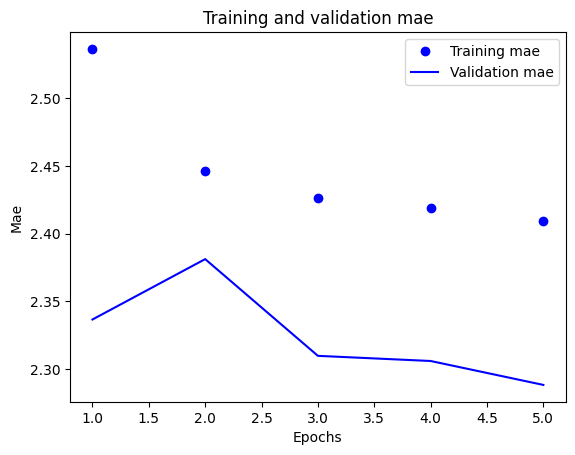

In [20]:
model = new_model(temporal_weight_range=[0.0, 2.0], l2_factor=1e-2, dropout_rate=0.5, 
                  final_activation=None, fit_residual=True)
compile_and_fit(model, 0)

In [21]:
evaluate_model(0)

26/26 [==============================] - 3s 109ms/step - loss: 10.0214 - mae: 2.4364
Test MAE: 2.44 for model tag: 0


&uarr; 2.62 was the test MAE for the common-sense model, 2.45 was the test MAE for the LSTM with dropout! Stacked LSTM was 2.39

# &darr; remove things 1 at a time

We should see validation MSE/MAE increase for each thing removed.

Epoch 1/5
810/819 [============================>.] - ETA: 0s - loss: 10.7965 - mae: 2.5222
Epoch 1: val_mae improved from inf to 2.33494, saving model to data/models/jena_dense_1.keras
819/819 [==============================] - 10s 11ms/step - loss: 10.7894 - mae: 2.5215 - val_loss: 9.2427 - val_mae: 2.3349
Epoch 2/5
819/819 [==============================] - ETA: 0s - loss: 10.1159 - mae: 2.4454
Epoch 2: val_mae improved from 2.33494 to 2.30138, saving model to data/models/jena_dense_1.keras
819/819 [==============================] - 9s 11ms/step - loss: 10.1159 - mae: 2.4454 - val_loss: 9.0165 - val_mae: 2.3014
Epoch 3/5
810/819 [============================>.] - ETA: 0s - loss: 9.9667 - mae: 2.4260
Epoch 3: val_mae did not improve from 2.30138
819/819 [==============================] - 9s 11ms/step - loss: 9.9630 - mae: 2.4257 - val_loss: 9.2380 - val_mae: 2.3317
Epoch 4/5
807/819 [============================>.] - ETA: 0s - loss: 9.8413 - mae: 2.4110
Epoch 4: val_mae did not improv

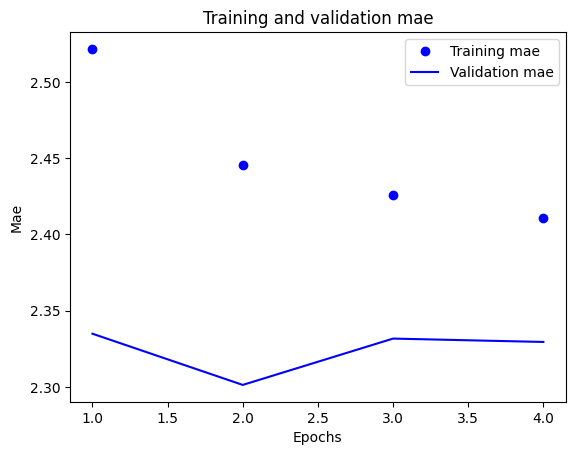

In [22]:
model = new_model(temporal_weight_range=None, l2_factor=1e-2, dropout_rate=0.5,
                  final_activation=None, fit_residual=True)
compile_and_fit(model, 1)

Epoch 1/5
810/819 [============================>.] - ETA: 0s - loss: 58.7084 - mae: 5.4002
Epoch 1: val_mae improved from inf to 2.65126, saving model to data/models/jena_dense_2.keras
819/819 [==============================] - 10s 11ms/step - loss: 58.3116 - mae: 5.3797 - val_loss: 11.5729 - val_mae: 2.6513
Epoch 2/5
817/819 [============================>.] - ETA: 0s - loss: 18.5326 - mae: 3.2762
Epoch 2: val_mae improved from 2.65126 to 2.55468, saving model to data/models/jena_dense_2.keras
819/819 [==============================] - 9s 11ms/step - loss: 18.5319 - mae: 3.2761 - val_loss: 11.0040 - val_mae: 2.5547
Epoch 3/5
816/819 [============================>.] - ETA: 0s - loss: 17.9771 - mae: 3.2188
Epoch 3: val_mae improved from 2.55468 to 2.55436, saving model to data/models/jena_dense_2.keras
819/819 [==============================] - 9s 11ms/step - loss: 17.9775 - mae: 3.2187 - val_loss: 10.8676 - val_mae: 2.5544
Epoch 4/5
816/819 [============================>.] - ETA: 0s - l

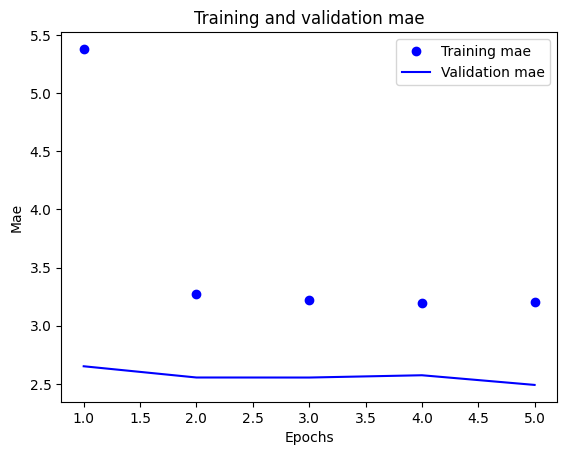

In [23]:
model = new_model(temporal_weight_range=None, l2_factor=1e-2, dropout_rate=0.5,
                  final_activation=sigmoid_range, fit_residual=False)
compile_and_fit(model, 2)

Epoch 1/5
818/819 [============================>.] - ETA: 0s - loss: 35.3715 - mae: 4.5499
Epoch 1: val_mae improved from inf to 3.99577, saving model to data/models/jena_dense_3.keras
819/819 [==============================] - 10s 11ms/step - loss: 35.3680 - mae: 4.5496 - val_loss: 26.2842 - val_mae: 3.9958
Epoch 2/5
817/819 [============================>.] - ETA: 0s - loss: 28.5495 - mae: 4.0512
Epoch 2: val_mae improved from 3.99577 to 3.24383, saving model to data/models/jena_dense_3.keras
819/819 [==============================] - 9s 11ms/step - loss: 28.5442 - mae: 4.0510 - val_loss: 17.0223 - val_mae: 3.2438
Epoch 3/5
812/819 [============================>.] - ETA: 0s - loss: 25.7360 - mae: 3.8436
Epoch 3: val_mae improved from 3.24383 to 2.69033, saving model to data/models/jena_dense_3.keras
819/819 [==============================] - 9s 11ms/step - loss: 25.7288 - mae: 3.8429 - val_loss: 12.0495 - val_mae: 2.6903
Epoch 4/5
817/819 [============================>.] - ETA: 0s - l

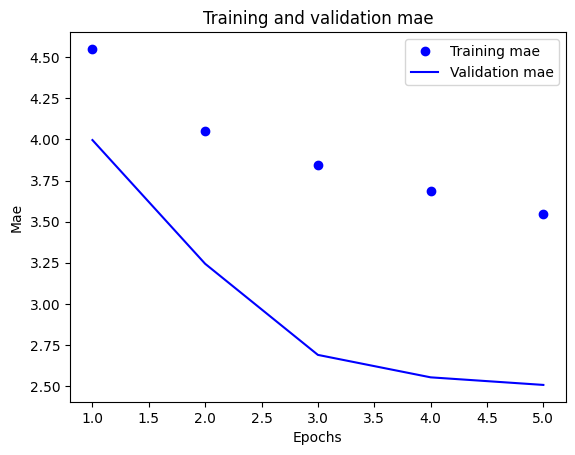

In [24]:
model = new_model(temporal_weight_range=None, l2_factor=1e-2, dropout_rate=0.5,
                  final_activation=None, fit_residual=False)
compile_and_fit(model, 3)

Epoch 1/5
812/819 [============================>.] - ETA: 0s - loss: 11.9212 - mae: 2.6719
Epoch 1: val_mae improved from inf to 2.65857, saving model to data/models/jena_dense_4.keras
819/819 [==============================] - 9s 11ms/step - loss: 11.8948 - mae: 2.6689 - val_loss: 11.3093 - val_mae: 2.6586
Epoch 2/5
809/819 [============================>.] - ETA: 0s - loss: 8.7708 - mae: 2.3249
Epoch 2: val_mae improved from 2.65857 to 2.54442, saving model to data/models/jena_dense_4.keras
819/819 [==============================] - 9s 11ms/step - loss: 8.7621 - mae: 2.3237 - val_loss: 10.3343 - val_mae: 2.5444
Epoch 3/5
807/819 [============================>.] - ETA: 0s - loss: 8.0722 - mae: 2.2324
Epoch 3: val_mae did not improve from 2.54442
819/819 [==============================] - 9s 11ms/step - loss: 8.0663 - mae: 2.2315 - val_loss: 14.0785 - val_mae: 2.9695
Epoch 4/5
815/819 [============================>.] - ETA: 0s - loss: 7.6578 - mae: 2.1749
Epoch 4: val_mae did not improv

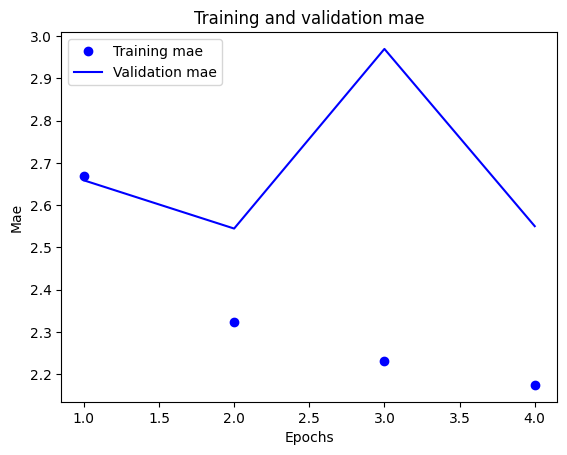

In [25]:
model = new_model(temporal_weight_range=None, l2_factor=None, dropout_rate=None,
                  final_activation=None, fit_residual=False)
compile_and_fit(model, 4)

Let's try the best model again with data augmentation &darr;

Epoch 1/5
810/819 [============================>.] - ETA: 0s - loss: 12.4965 - mae: 2.7197
Epoch 1: val_mae improved from inf to 2.30533, saving model to data/models/jena_dense_5.keras
819/819 [==============================] - 10s 11ms/step - loss: 12.4809 - mae: 2.7180 - val_loss: 9.0859 - val_mae: 2.3053
Epoch 2/5
814/819 [============================>.] - ETA: 0s - loss: 10.5469 - mae: 2.5082
Epoch 2: val_mae improved from 2.30533 to 2.29274, saving model to data/models/jena_dense_5.keras
819/819 [==============================] - 9s 11ms/step - loss: 10.5480 - mae: 2.5084 - val_loss: 8.8936 - val_mae: 2.2927
Epoch 3/5
817/819 [============================>.] - ETA: 0s - loss: 10.2888 - mae: 2.4776
Epoch 3: val_mae improved from 2.29274 to 2.28476, saving model to data/models/jena_dense_5.keras
819/819 [==============================] - 9s 11ms/step - loss: 10.2927 - mae: 2.4782 - val_loss: 8.8821 - val_mae: 2.2848
Epoch 4/5
817/819 [============================>.] - ETA: 0s - loss

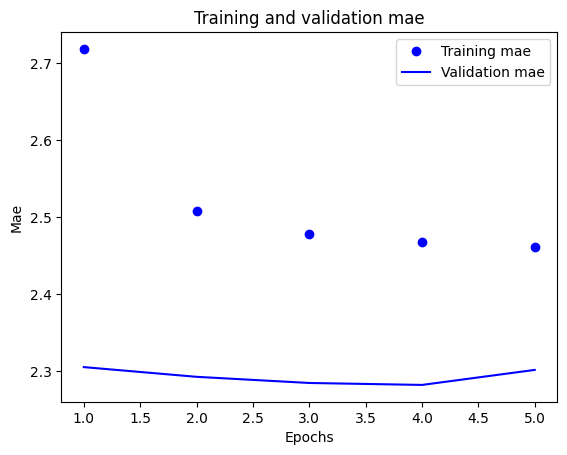

In [26]:
model = new_model(temporal_weight_range=[0.0, 2.0], l2_factor=1e-2, dropout_rate=0.5, 
                  final_activation=None, fit_residual=True)
compile_and_fit(model, 5, augment=True)

&uarr; this ends up pretty much the same as without augmentation but ... looks like augmentation really hurts the starter model &darr;

Epoch 1/5
808/819 [============================>.] - ETA: 0s - loss: 18.5198 - mae: 3.3468
Epoch 1: val_mae improved from inf to 2.67906, saving model to data/models/jena_dense_6.keras
819/819 [==============================] - 10s 11ms/step - loss: 18.4521 - mae: 3.3406 - val_loss: 11.5714 - val_mae: 2.6791
Epoch 2/5
810/819 [============================>.] - ETA: 0s - loss: 12.2405 - mae: 2.7595
Epoch 2: val_mae did not improve from 2.67906
819/819 [==============================] - 9s 11ms/step - loss: 12.2247 - mae: 2.7578 - val_loss: 14.0273 - val_mae: 2.9277
Epoch 3/5
818/819 [============================>.] - ETA: 0s - loss: 10.8780 - mae: 2.6002
Epoch 3: val_mae did not improve from 2.67906
819/819 [==============================] - 9s 11ms/step - loss: 10.8762 - mae: 2.6000 - val_loss: 12.8661 - val_mae: 2.8203
Epoch 3: early stopping


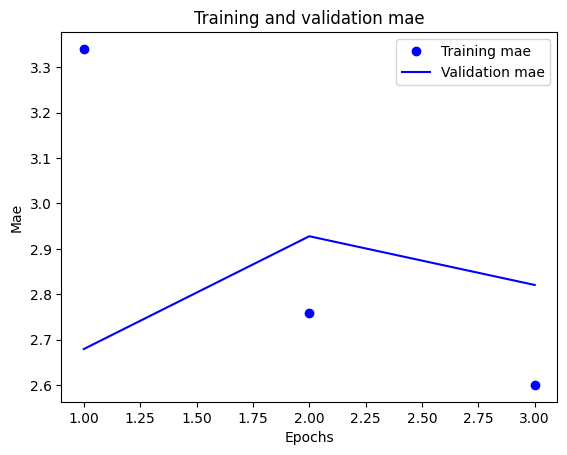

In [27]:
model = new_model(temporal_weight_range=None, l2_factor=None, dropout_rate=None,
                  final_activation=None, fit_residual=False)
compile_and_fit(model, 6, augment=True)

Note: augmentation helped the some models when using a lower dropout rate - in the end, dropout does a better job with this problem.